In [1]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import openpyxl
pd.options.display.max_columns = None

#Dataviz
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

#NLP
import re
import string
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from nltk.collocations import *
from collections import Counter
from nltk import bigrams
from nltk import trigrams
from nltk import ngrams

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from skmultilearn.adapt import MLkNN, MLARAM
from scipy.sparse import csr_matrix, lil_matrix

from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss


import unicodedata

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# personalização local
nps_df = pd.read_excel('TBL_BASE_GERAL_2020.xlsx')
nps_df.columns = nps_df.columns.str.lower()
nps_df.columns = nps_df.columns.str.replace('qnt_detrator', 'qtd_detrator')
nps_df.columns = nps_df.columns.str.replace('qnt_neutro', 'qtd_neutro')
nps_df.columns = nps_df.columns.str.replace('qnt_promotor', 'qtd_promotor')

In [3]:
nps_df.shape

(42011, 25)

In [4]:
nps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42011 entries, 0 to 42010
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dt_envio_nps       42011 non-null  object 
 1   ds_peri_mens_nps   42011 non-null  object 
 2   ds_grupo_pond      42011 non-null  object 
 3   prioridade         42011 non-null  object 
 4   ds_site            42011 non-null  object 
 5   qnt_resp           42011 non-null  int64  
 6   qtd_detrator       42011 non-null  int64  
 7   qtd_neutro         42011 non-null  int64  
 8   qtd_promotor       42011 non-null  int64  
 9   nm_gerente         35351 non-null  object 
 10  nm_coordenador     35180 non-null  object 
 11  nm_supervisor      35351 non-null  object 
 12  area               42011 non-null  object 
 13  dummy_atendimento  42011 non-null  object 
 14  contatos           42011 non-null  int64  
 15  celula_bd          35347 non-null  object 
 16  nr_pess            420

In [5]:
nps_df.head()

dt_envio_nps ds_peri_mens_nps ds_grupo_pond  prioridade  \
0  01/04/2020 12:08:14           Abr/20            E1     AGÊNCIA   
1  01/04/2020 12:08:14           Abr/20            E1     AGÊNCIA   
2  01/04/2020 12:08:14           Abr/20            E1     AGÊNCIA   
3  01/04/2020 12:08:14           Abr/20            E1  CARTÕES PJ   
4  01/04/2020 12:08:14           Abr/20            E1  CARTÕES PJ   

       ds_site  qnt_resp  qtd_detrator  qtd_neutro  qtd_promotor  \
0  SEM DOTAÇÃO         1             0           0             1   
1  SEM DOTAÇÃO         1             1           0             0   
2          VSP         1             1           0             0   
3  SEM DOTAÇÃO         1             0           0             1   
4  SEM DOTAÇÃO         1             0           0             1   

                   nm_gerente       nm_coordenador  \
0                         NaN                  NaN   
1                         NaN                  NaN   
2  RODRIGO GABRIEL DOS SANTOS  FERNANDA SILVA ROSA   
3                         NaN                  NaN   
4                         NaN                  NaN   

                    nm_supervisor         area       dummy_atendimento  \
0                             NaN           PJ       ÚNICO ATENDIMENTO   
1                             NaN           PJ       ÚNICO ATENDIMENTO   
2  CARLA CATHERINE CAMARGO FARIAS           PJ       ÚNICO ATENDIMENTO   
3                             NaN  CONTESTAÇÃO  MÚLTIPLOS ATENDIMENTOS   
4                             NaN           PJ  MÚLTIPLOS ATENDIMENTOS   

   contatos celula_bd   nr_pess  \
0         1       NaN  84338544   
1         1       NaN  95385837   
2         1    VAREJO  55527232   
3         2       NaN  87253791   
4         2       NaN  83814442   

                                           tx_coment  fila    tmo produto  \
0                                  atendimento otimo   120    NaN     NaN   
1                                                NaN    64    NaN     NaN   
2                          nao tive acesso a gerente    60  324.0     NaN   
3                                                NaN   386    NaN     NaN   
4  quero que mande um codigo de barras da minha f...    51    NaN     NaN   

  sintoma indc_nps indc_nps_full  nps_ponderado  
0     NaN        P      PROMOTOR            4.0  
1     NaN        D      DETRATOR            4.0  
2     NaN        D      DETRATOR            4.0  
3     NaN        P      PROMOTOR            4.0  
4     NaN        P      PROMOTOR            4.0

In [6]:
nps_df['ds_peri_mens_nps'].value_counts()

Mar/20    18534
Fev/20    15192
Abr/20     8285
Name: ds_peri_mens_nps, dtype: int64

In [7]:
# personalização local
nps_df['dt_ano_mes'] = nps_df['ds_peri_mens_nps']
nps_df['dt_ano_mes'] = nps_df['dt_ano_mes'].str.replace('Mar/20','202003')
nps_df['dt_ano_mes'] = nps_df['dt_ano_mes'].str.replace('Fev/20','202002')
nps_df['dt_ano_mes'] = nps_df['dt_ano_mes'].str.replace('Abr/20','202004')

In [8]:
nps_df['dt_ano_mes'].value_counts()

202003    18534
202002    15192
202004     8285
Name: dt_ano_mes, dtype: int64

### Filtros

In [9]:
nps_df = nps_df[(nps_df['tx_coment'].notna())]

In [10]:
nps_df = nps_df[nps_df['dt_ano_mes'].isin(['202004'])]

In [11]:
nps_df = nps_df[(nps_df['qtd_promotor'] <1)]
nps_df = nps_df[(nps_df['qtd_neutro'] <1)]
# nps_df = nps_df[(nps_df['qtd_detrator'] <1)]

nps_df['qtd_promotor'].sum(), nps_df['qtd_neutro'].sum(), nps_df['qtd_detrator'].sum()

(0, 0, 2529)

### NLP e Pré-Processamento de Texto

In [12]:
def removerAcentosECaracteresEspeciais(palavra):
    nfkd = unicodedata.normalize('NFKD', palavra)
    palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])
    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', palavraSemAcento)

In [13]:
nps_df['tx_coment'] = nps_df['tx_coment'].map(lambda x: removerAcentosECaracteresEspeciais(x))

In [14]:
nps_df['tx_coment'] = nps_df['tx_coment'].map(lambda x: x.lower())

In [143]:
stopwords = set(nltk.corpus.stopwords.words('portuguese'))

In [144]:
stopwords.clear()

In [145]:
stopwords.update(['a', 'o'])

In [146]:
evaluate = nps_df['tx_coment'].astype(str)

In [147]:
def removestopwords(texto):
    frases = []
    for palavras in texto:
        semstop = [p for p in palavras.split() if p not in stopwords]
        frases.append((semstop))
    return frases

In [148]:
removestopwords(evaluate)

[['nao', 'tive', 'acesso', 'gerente'],
 ['nao', 'fui', 'atendido'],
 ['fiquei',
  'mais',
  'de',
  'meia',
  'hora',
  'e',
  'ninguem',
  'atendeu',
  'desliguei',
  'sem',
  'atendimento',
  'muito',
  'tempo',
  'aguardando',
  'e',
  'nao',
  'atenderam',
  'desisti',
  'sem',
  'atendimento'],
 ['nao',
  'consegui',
  'de',
  'forma',
  'alguma',
  'falar',
  'com',
  'algum',
  'atendente',
  'em',
  'nenhuma',
  'das',
  'opcoes',
  'do',
  'contato',
  'telefonico',
  'um',
  'absurdo',
  'pois',
  'estamos',
  'de',
  'quarentena',
  'bancos',
  'fechados',
  'e',
  'precisando',
  'resolver',
  'as',
  'coisas'],
 ['sistema', 'de', 'telefone', 'de', 'vcs', 'e', 'pessimo'],
 ['13', 'minutos', 'aguardando', 'para', 'ser', 'atendida', 'ate', 'desistir'],
 ['atendente',
  'nao',
  'esclareceu',
  'minha',
  'solicitacao',
  'e',
  'desligou',
  'do',
  'nada'],
 ['ara',
  'socorrer',
  'pequenas',
  'empresas',
  'se',
  'consequir',
  'me',
  'avise',
  'obrigado',
  'ar',
  'i

### WordCloud

In [ ]:
wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue', width=600, height=400)
wordcloud.generate(evaluate.to.string())
wordcloud.to_image()

### Feature Engineering

In [15]:
nps_df['cod_index'] = nps_df.index

In [16]:
nps_df['qtd_caracteres'] = pd.Series(nps_df['tx_coment']).str.len()

In [17]:
nps_df['qtd_palavras'] = pd.Series(nps_df['tx_coment']).str.split().str.len()

### Glossário

#### base do glossário

In [66]:
'''
def import_glossario(glossario_tema, arquivo='Glossários NPS.xlsx', planilha='Consolidada', caminho='C:/_PY/_CURRICULUM/NPS'):
    """
    Objetivo da Função: A função tem como objetivo importar as palavras do glossário
    Você passa o caminho (a pasta onde eles se encontram), a função lista
    os arquivos, importa eles e depois contatena.

    Inputs:
    [glossario_tema]: Tema do Glossário
    [arquivo]: Nome do arquivo que esta o glossário
    [planilha]: Planilha especifica que se encontra o Glossario
    [caminho]: Pasta onde se encontra o arquivo do glossário

    Outputs:
    [glossario_lista]: uma lista com as palavras do glossário

    """

    glossario = smb.from_dir(caminho + arquivo, sheet_nm = planilha)

    glossario_lista = glossario['Palavras'].to_list()
    print(len(glossario_lista), termos)
    print(glossario_lista)
    return glossario_lista

glossario_lista = import_glossario(glossario_tema = glossario)
glossario_lista = list(set([i.strip() for i in glossario_lista]))
'''

In [152]:
arquivo_nome = 'Glossários NPS.xlsx'
arquivo = pd.ExcelFile(arquivo_nome)

In [153]:
sheet_name = arquivo.sheet_names

In [154]:
#basic = pd.DataFrame()
for i in sheet_name:
    glossario = pd.read_excel(arquivo_nome, sheet_name=i)
    glossario['Palavras'] = glossario['Palavras'].map(lambda x: x.lower())
    #glossario['Palavras'] = glossario['Palavras'].map(lambda x: re.sub('[,\.!?]', '', x))
    glossario['Palavras'] = glossario['Palavras'].map(lambda x: removerAcentosECaracteresEspeciais(x))
    glossario_lista = glossario['Palavras'].to_list()
    print(len(glossario_lista))
    print(i)
    print(glossario_lista)
#return glossario_lista

31
queda_de_ligacao
['cai', 'caia', 'caiu', 'caindo', 'caem', 'cairem', 'derrubado', 'derrubam', 'derruba', 'derrubou', 'desligaram', 'desligou', 'desliga', 'desligaram', 'encerra', 'ligacao', 'ligacao', 'encerram', 'encerrou', 'acho que caiu', 'caiu a ligacao', 'continuar o registro', 'estgava em ligacao', 'explicar tudo de novo', 'ja tinha comecado a registrar', 'nao concluiram o atendimento', 'nao quero explicar de novo', 'nao vou explicar de novo', 'vou ter que explicar de novo', 'vou ter que explicar novamente', 'chamada perdida']
57
qualidade_de_atendimento
['atendimento ao cliente ruim', 'atendimento caotico', 'atendimento central', 'atendimento central de atendimento', 'atencimento com o cliente muito ruim', 'atendimento de baixa qualidade', 'atendimento eficiente', 'atendimento falho', 'atendimento horrivel', 'atendimento humano', 'atendimento ineficiente', 'atendimento muito ruim', 'atendimento pessimo', 'atendimento ridiculo', 'atendimento uma merda', 'call center', 'callcen

87
resolucao
['ajuda', 'consegue', 'conseguir', 'consigo', 'deixar na mao', 'deixaram na mao', 'demanda', 'devolucao', 'devolve', 'devolveu', 'devolvido', 'exito', 'mandaram', 'me responde', 'mes', 'meu problema nao foi resolvido', 'minha solicitacao nao foi atendida', 'muitas ligacoes', 'nada', 'nao consegui resolver meu problema', 'nao consigo', 'nao consigo resolver', 'nao cumprimento', 'nao cumpriram', 'nao foi', 'nao foi atendido', 'nao foi esclarecida', 'nao foi feito', 'nao foi resolvido', 'nao foi resolvido meu problema', 'nao me ajudou', 'nao obtive', 'nao resolucao do problema', 'nao resolve', 'nao resolvem', 'nao resolvem nada', 'nao resolveram', 'nao resolveram meu problema', 'nao resolveram o meu problema', 'nao resolveram o problema', 'nao resolveu', 'nao resolveu meu problema', 'nao resolveu nada', 'nao resolveu o meu problema', 'nao resolveu o problema', 'nao resolvi', 'nao resolvi meu problema', 'nao resolvida', 'nao responde', 'nao responderam', 'nao souberam', 'probl

#### MATCH - primeiro exemplo - preencha com os demais glossários

In [155]:
sheet_name

['queda_de_ligacao',
 'qualidade_de_atendimento',
 'bloqueio_de_fraudes',
 'ura_central',
 'fila_de_espera',
 'erro_aplicativo_ib',
 'erro_nota',
 'resolucao',
 'regra_de_negocio',
 'gerente_e_agencia',
 'sem_classificacao']

In [18]:
# ajuste manual
x_queda_de_ligacao = nps_df
x_qualidade_de_atendimento = nps_df
x_bloqueio_de_fraudes = nps_df
x_ura_central = nps_df
x_fila_de_espera = nps_df
x_erro_aplicativo_ib = nps_df
x_erro_nota = nps_df
x_resolucao = nps_df
x_regra_de_negocio = nps_df
x_gerente_e_agencia = nps_df
x_sem_classificacao= nps_df

### Verifica se o texto contém alguma das palavras da lista (match)

In [19]:
match = ['cai', 'caia', 'caiu', 'caindo', 'caem', 'cairem', 'derrubado', 'derrubam', 'derruba', 'derrubou', 'desligaram', 'desligou', 'desliga', 'desligaram', 'encerra', 'ligacao', 'ligacao', 'encerram', 'encerrou', 'acho que caiu', 'caiu a ligacao', 'continuar o registro', 'estgava em ligacao', 'explicar tudo de novo', 'ja tinha comecado a registrar', 'nao concluiram o atendimento', 'nao quero explicar de novo', 'nao vou explicar de novo', 'vou ter que explicar de novo', 'vou ter que explicar novamente', 'chamada perdida']
x_queda_de_ligacao['match'] = x_queda_de_ligacao['tx_coment'].str.contains('|'.join(match))
x_queda_de_ligacao = x_queda_de_ligacao[x_queda_de_ligacao['match']==True] 

In [20]:
match = ['atendimento ao cliente ruim', 'atendimento caotico', 'atendimento central', 'atendimento central de atendimento', 'atencimento com o cliente muito ruim', 'atendimento de baixa qualidade', 'atendimento eficiente', 'atendimento falho', 'atendimento horrivel', 'atendimento humano', 'atendimento ineficiente', 'atendimento muito ruim', 'atendimento pessimo', 'atendimento ridiculo', 'atendimento uma merda', 'call center', 'callcenter', 'central de atendimento', 'atendimento fraco', 'central ineficiente', 'descaso com o cliente', 'desinformados', 'despreparados', 'respreparo', 'desrespeito', 'educacao', 'empatia', 'falha humana', 'falta de assistencia', 'falta de atencao', 'falta de compreensao ao cliente', 'falta de compromisso', 'falta de comunicacao', 'falta de conhecimento', 'falta de consideracao', 'falta de informacao', 'falta de informacoes', 'falta de orientacao', 'falta de respeito', 'falta de tato', 'falta de treinamento', 'grosseiro', 'incompetencia', 'incompetente', 'incompetentes', 'ineficiencia de atendimento', 'ineficiencia no atendimento', 'informacao divergente', 'inoperancia', 'insatisfacao com atendimento', 'insatisfacao com o atendimento', 'insatisfacao no atendimento', 'inseguranca', 'mal atendida', 'mal atendido', 'mal atendimento', 'mal educado']
x_qualidade_de_atendimento['match'] = x_qualidade_de_atendimento['tx_coment'].str.contains('|'.join(match))
x_qualidade_de_atendimento = x_qualidade_de_atendimento[x_qualidade_de_atendimento['match']==True] 

In [21]:
match = ['bloqueado', 'bloquear', 'bloqueio preventivo', 'cartao cancelado por fraude', 'clonagem de cartoes', 'compra nao reconhecida', 'conta bloquada por fraude', 'efetuaram debitos nao autorizados', 'falta de seguranca', 'fraudado', 'fraude', 'meu cartao foi bloquado', 'meu cartao foi clonado', 'mexer na minha conta', 'mexeram na minha conta', 'minha conta foi bloqueada', 'minha conta foi invadida', 'nao autorizei', 'problemas de fraude', 'bloqueio', 'tentativa de compras', 'tentativas de compras', 'tentativas de compra', 'tentativas de invasao na minha conta', 'tirando dinheiro da minha conta', 'transacao nao reconhecida', 'invasao da minha conta', 'invadiram minha conta', 'hackers invadiu a conta', 'problema de clonagem', 'fui hackeado', 'uma conta nao autorizada', 'uma compra nao autorizada', 'tem uma conta nao autorizada', 'fizeram uma compra', 'clonado novamente', 'tentativa de fraudes', 'sofri um golpe', 'fraude e estelionatario', 'cartao de credito foi usado indevidamente', 'cancelado por seguranca', 'fraude na minha conta', 'contestacao', 'cartoes de forma fraudulenta', 'nao reconheco a transacao', 'nao reconheco a compra', 'nao foi eu que fiz a compra', 'nao foi eu que realizei a compra']
x_bloqueio_de_fraudes['match'] = x_bloqueio_de_fraudes['tx_coment'].str.contains('|'.join(match))
x_bloqueio_de_fraudes = x_bloqueio_de_fraudes[x_bloqueio_de_fraudes['match']==True] 

In [22]:
match = ['a gente custa falar com uma atendente', 'a maquina nem sempre nos responde', 'achar as opcoes', 'a ura precisa ser mais funcional', 'alguem de carne e osso', 'apartava varias opcoes', 'aperta', 'aperta este aperta aquele', 'aperta um milhao de opcoes', 'apertar ate chegar no atendente', 'apertar numero tal', 'apertar tantos numeros', 'apertar varias opcoes', 'apertar varios numeros', 'assistente virtual', 'atalhos', 'atalhos demais', 'atalhos muito longos', 'atendente nao virtual', 'atendente virtual nao da opcao', 'atendimento digital', 'atendimento eletronico', 'atendimento eletronico confuso', 'atendimento eletronico meio confuso', 'atendimento eletronico e meio confuso', 'atendimento eletronico muito cansativo', 'atendimento humano', 'atendimento inacessivel', 'atendimento remoto', 'atendimento robotizado', 'atentimento virtual horrivel', 'atendimento virtual um saco', 'caminho muito complexo pelo telefone', 'canal', 'canal de atendimento mais claro', 'canal de telefone', 'canal especifico para resolver o problema', 'carne e osso', 'central e muito complexa', 'chegar', 'chegar a atendente', 'chegar ao objetivo da ligacao', 'chegar no atendimento de destino', 'chegar no atendimento humano', 'complexo', 'complexo o acesso', 'complexo o processo para achar a opcao', 'complicada', 'complicado', 'contato com uma pessoa de carne e osso', 'contato inicial apenas com maquinas', 'custa achar a opcao que precisa', 'custa ate chegar a opcao desejada', 'custa demais', 'custa muito em tempo o atendimento', 'demora demais atendimento eletronico', 'demora no atendimento eletronico', 'dmora para falar com atendente', 'descricao das opcoes no canal', 'dificil achar as opcoes', 'dificil falar', 'dificil falar com alguem', 'dificil falar com um atendente', 'dificuldade para falar com alguem', 'dificuldade para falar com um atendente', 'diminuir a quantidade de numeros', 'diminuir os atalhos', 'eletronica', 'eletronica', 'eletronico', 'essa ura e um lixo', 'falar', 'falar com alguem', 'falar com maquina nao resolve', 'falar com pessoas nao com maquinas', 'falar com um atendente', 'falar com um atendente de carne osso', 'falar com um humano', 'falha no menu eletronico', 'falta atendimento de carne e osso', 'falta de objetivo para as opcoes', 'ficou complexo as escolhas', 'funcional', 'gravacao', 'hora falando com maquina', 'humano', 'inacessivel', 'incluir todos os atalhos', 'mais opcoes', 'maquina', 'maquina que nao resolve nada', 'maquinas', 'melhorar a ura', 'melhorar os atalhos do atendimento', 'menos burocracia para chegar no atendimento', 'menos maquina sem rodeios', 'menos passos para chegar ao atendente', 'menu', 'menu complexo', 'menu confuso', 'menu de opcoes mais objetivo', 'menu eletronico complexo', 'menu inicial mais rapido e objetivo', 'menu longo e complexo', 'menu mais simples e objetivo', 'menus', 'menus mais objetivos', 'muitas opcoes na ura', 'muitas opcoes para chegar ao atendente', 'muito complexo e lotado de opcoes', 'muito complexo fical falando com uma maquina', 'muito confuso e pouco funcional', 'muito rodeio para chegar na opcao', 'muitos atalhos', 'menu eletronico', 'nada funcional e muito confuso', 'nao consegui chegar no canal', 'nao consegui falar com atendente', 'nao consegui falar com um atendente', 'nao consigo falar com atendente', 'o atendimento deveria ser mais objetivo', 'o atendimento humano mais rapido', 'o canal podeira das as opcoes', 'objetivo', 'obrigados a interagir com uma maquina', 'opcao', 'opcao de falar com atendente', 'opcoes', 'opcoes funcionais', 'opcoes mais claras', 'opcoes mais objetivas', 'opcoes nao tornam funcional', 'otimizar o numero de opcoes', 'passa de numero', 'pessima funcionalidade este canal', 'pouco intuitiva', 'precisa de opcoes mais claras', 'robo', 'robotizado', 'secretaria', 'secretaria eletronica disfuncional', 'sistema de comunicacao complexo', 'so falo com robo', 'so tem robo nessa central', 'atendimento eletronico tem opcoes insatisfatorias', 'tentar mais tarde', 'ter um canal direto para um atendente', 'ura', 'ura complicada', 'ura confusa', 'ura dificil', 'ura eletronica esta horrivel', 'ura horrivel', 'ura irritante', 'ura lixo', 'ura melhor', 'ura terrivel', 'virtual']
x_ura_central['match'] = x_ura_central['tx_coment'].str.contains('|'.join(match))
x_ura_central = x_ura_central[x_ura_central['match']==True] 

In [23]:
match = ['agil', 'agilidade', 'atende', 'atendem', 'atenden', 'atender', 'atendida', 'atendido', 'atendo', 'consegui', 'contato', 'de mora', 'demora', 'demorado', 'demorou', 'dificil', 'dificuldade', 'enrolado', 'espera', 'esperando', 'esperei', 'lentidao', 'lentidao', 'linha', 'minutos', 'muito longo', 'nao ate dimento', 'lento', 'nao consigo fala', 'nao consigo falar', 'nem sempre', 'nunca atende', 'sem sucesso', 'tempao', 'tempo', 'tempo de espera', 'tentando', 'varias', 'varias', 'ninguem', 'ninguem', 'nao consegui ser atendido', 'o atendimento nao e agil', 'agilidade zero', 'nunca tem agilidade', 'nunca sao ageis', 'falta de agilidade', 'nunca atendem dificil atenderem', 'esperando atender', 'demora para atender', 'nao consegui atendimento', 'nao consegui ser atendido', 'dificuldade em ser atendido', 'demora demais', 'demora muito', 'quanta demora', 'como demora', 'demorei muito na linha', 'fiquei muito na linha', 'muito tempo na linha', 'tempo em linha', 'minutos na linha', 'horas na linha', 'tempo demais na linha', 'atendimento lento demais', 'muito lento', 'que lentidao', 'fora a lentidao']
x_fila_de_espera['match'] = x_fila_de_espera['tx_coment'].str.contains('|'.join(match))
x_fila_de_espera = x_fila_de_espera[x_fila_de_espera['match']==True] 

In [24]:
match = ['aplicativo indisponivel', 'app indisponivel', 'problema no aplicativo', 'problema no app', 'problema no site', 'problemas no aplicativo', 'problemas no app', 'problemas no site', 'problema na pagina', 'problemas na pagina', 'erro no app', 'erro no aplicativo', 'site indisponivel', 'aplicativo indisponivel', 'app', 'internet', 'pagina', 'erro no sistema', 'fora do ar', 'problema tecnico', 'problemas tecnico', 'sem sistema', 'sistema nao esta disponivel', 'sistema indisponivel', 'sistema inoperante']
x_erro_aplicativo_ib['match'] = x_erro_aplicativo_ib['tx_coment'].str.contains('|'.join(match))
x_erro_aplicativo_ib = x_erro_aplicativo_ib[x_erro_aplicativo_ib['match']==True] 

In [25]:
match = ['digitei errado', 'nota seria', 'digitacao errada', 'nota e 10', 'bem atendida', 'corretamente', 'desculpa coloquei a nota errada', 'desculpa dei nota errada', 'digitei errado', 'dou mais', 'nota nao e fiel', 'referente ao que', 'sem motivos', 'sinceramente', 'tenho poucos contatos']
x_erro_nota['match'] = x_erro_nota['tx_coment'].str.contains('|'.join(match))
x_erro_nota = x_erro_nota[x_erro_nota['match']==True] 

In [26]:
match = ['ajuda', 'consegue', 'conseguir', 'consigo', 'deixar na mao', 'deixaram na mao', 'demanda', 'devolucao', 'devolve', 'devolveu', 'devolvido', 'exito', 'mandaram', 'me responde', 'mes', 'meu problema nao foi resolvido', 'minha solicitacao nao foi atendida', 'muitas ligacoes', 'nada', 'nao consegui resolver meu problema', 'nao consigo', 'nao consigo resolver', 'nao cumprimento', 'nao cumpriram', 'nao foi', 'nao foi atendido', 'nao foi esclarecida', 'nao foi feito', 'nao foi resolvido', 'nao foi resolvido meu problema', 'nao me ajudou', 'nao obtive', 'nao resolucao do problema', 'nao resolve', 'nao resolvem', 'nao resolvem nada', 'nao resolveram', 'nao resolveram meu problema', 'nao resolveram o meu problema', 'nao resolveram o problema', 'nao resolveu', 'nao resolveu meu problema', 'nao resolveu nada', 'nao resolveu o meu problema', 'nao resolveu o problema', 'nao resolvi', 'nao resolvi meu problema', 'nao resolvida', 'nao responde', 'nao responderam', 'nao souberam', 'problema nao resolvido', 'probrema', 'protocolo', 'resolucao', 'resolutibilidade', 'resolve', 'resolver', 'resolveram', 'resolveu', 'resolvi', 'resolvida', 'resolvido', 'respondem', 'responder', 'responderam', 'resposta', 'soluciono', 'solucionou', 'caloteiros', 'concluir', 'consentimento', 'enviados', 'descontado', 'descontar', 'duplicidade', 'enviado', 'enviaram', 'envio', 'enviaram', 'nao chega', 'nao chegou', 'nao pedi', 'nao recebi', 'probleminha', 'resgate', 'ressarcimento']
x_resolucao['match'] = x_resolucao['tx_coment'].str.contains('|'.join(match))
x_resolucao = x_resolucao[x_resolucao['match']==True] 

In [27]:
match = ['anuidade', 'entrega do cartao', 'autorizacao', 'biometria', 'boleta', 'boleto', 'borocracia', 'burocracia', 'burocratico', 'cambio', 'cobranca', 'cobrando', 'cobrar', 'conta', 'contas', 'contrato', 'conta', 'contas', 'contrato', 'credito', 'criterios', 'debitar', 'debitaram', 'debitou', 'desconto', 'estornados', 'estorno', 'extorno', 'fatura', 'financiamento', 'fazer', 'juris', 'juros', 'jurus', 'libera', 'leberacao', 'liberar', 'linha de credito', 'limite', 'morosidade', 'negado', 'negaram', 'negativas', 'ngociacao', 'negociar', 'pagamento', 'parcelamento', 'pix', 'pontos', 'previdencia', 'processo', 'produto', 'produtos', 'proposta', 'recursos', 'seguro', 'senha', 'spc', 'tarifa', 'tarifas', 'taxa', 'taxas', 'titulo', 'transferencia', 'tarifa mensal', 'liberacao de cheque especial', 'encargos', 'aumento de limite', 'liberacao linha de credito', 'reducao de limite', 'financiar', 'pacote de servicos']
x_regra_de_negocio['match'] = x_regra_de_negocio['tx_coment'].str.contains('|'.join(match))
x_regra_de_negocio = x_regra_de_negocio[x_regra_de_negocio['match']==True] 

In [28]:
match = ['agencia', 'gerente', 'gerente grosseiro', 'gerente nunca resolve meu problema', 'agencia nunca resolvemeu problema', 'gerente me tratou mal', 'gerente nao retorna meu contato', 'nao consigo falar com gerente', 'nao consigo falar na agencia', 'gerente arrogante', 'gerente grosso', 'falta de educacao do gerente', 'gerente desorganizado', 'agencia desorganizada', 'gerente derespeitoso', 'gerente mal educado', 'gerente pessimo', 'ninguem me atende na agencia', 'equipamentos da agencia sempre quebrado', 'agencia sempre cheia', 'fila enorme na agencia', 'fila desorganizada', 'atendimento da agencia e demorado', 'caixa eletronico quebrado', 'agencia nao atende telefone', 'gerente rispido', 'nao tem funcionarios suficiente para atendimento na agencia', 'gerente nunca esta disponivel', 'gerente atende com ma vontade', 'agencia fechada', 'nao recebo retorno do gerente', 'nao recebo retorno da agencia', 'gerente me destratou', 'falta envelope na agencia', 'um caixa so atendendo', 'pessimo atendimento na agencia', 'sempre muda o gerente', 'mudava gerente', 'falta de profissionalismo dos gerentes', 'gerente nao ajuda', 'gerente mal treinado', 'gerente nao e confiavel', 'gerente com pouco conhecimento', 'gerente stressadinho']
x_gerente_e_agencia['match'] = x_gerente_e_agencia['tx_coment'].str.contains('|'.join(match))
x_gerente_e_agencia = x_gerente_e_agencia[x_gerente_e_agencia['match']==True] 

In [29]:
match = ['aa', 'achei q mereceu', 'adivinha', 'ai e com vcs', 'ainda fui justo', 'alguns', 'arte', 'devem saber', 'escolha minha', 'familia', 'fatos ocorridos', 'https', 'i', 'interessa', 'kbu', 'link', 'me liga', 'menciono depois', 'mereceu', 'mim ligue', 'muita coisa', 'n a', 'nada', 'nada a declarar', 'nao', 'nao coneco', 'nao me comprometo', 'nao sei', 'nao sou cliente', 'nao sou empresa', 'nem sei', 'nenhum', 'nihill', 'pessoais', 'pouca experiencia com santander', 'sei la', 'sem comentario', 'sem mais', 'sem resposta', 'ta bom obrigado', 'todos possivel', 'tudos', 'varios', 'voces sabem']
x_sem_classificacao['match'] = x_sem_classificacao['tx_coment'].str.contains('|'.join(match))
x_sem_classificacao = x_sem_classificacao[x_sem_classificacao['match']==True] 

In [30]:
x_queda_de_ligacao['x_queda_de_ligacao'] = 1
x_qualidade_de_atendimento['x_qualidade_de_atendimento'] = 1
x_bloqueio_de_fraudes['x_bloqueio_de_fraudes'] = 1
x_ura_central['x_ura_central'] = 1
x_fila_de_espera['x_fila_de_espera'] = 1
x_erro_aplicativo_ib['x_erro_aplicativo_ib'] = 1
x_erro_nota['x_erro_nota'] = 1
x_resolucao['x_resolucao'] = 1
x_regra_de_negocio['x_regra_de_negocio'] = 1
x_gerente_e_agencia['x_gerente_e_agencia'] = 1
x_sem_classificacao['x_sem_classificacao'] = 1

C:\Users\vinic\AppData\Local\Temp/ipykernel_11460/888981122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_queda_de_ligacao['x_queda_de_ligacao'] = 1
C:\Users\vinic\AppData\Local\Temp/ipykernel_11460/888981122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_qualidade_de_atendimento['x_qualidade_de_atendimento'] = 1
C:\Users\vinic\AppData\Local\Temp/ipykernel_11460/888981122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [32]:
nps_df2 = nps_df.join([
    x_queda_de_ligacao['x_queda_de_ligacao'],
    x_qualidade_de_atendimento['x_qualidade_de_atendimento'], 
    x_bloqueio_de_fraudes['x_bloqueio_de_fraudes'], 
    x_ura_central['x_ura_central'], 
    x_fila_de_espera['x_fila_de_espera'], 
    x_erro_aplicativo_ib['x_erro_aplicativo_ib'], 
    x_erro_nota['x_erro_nota'], 
    x_resolucao['x_resolucao'], 
    x_regra_de_negocio['x_regra_de_negocio'], 
    x_gerente_e_agencia['x_gerente_e_agencia'], 
    x_sem_classificacao['x_sem_classificacao']])
#nps_df = nps_df.join([x_queda_de_ligacao['x_queda_de_ligacao'],x_qualidade_de_atendimento['x_qualidade_de_atendimento']])
nps_df = nps_df2

In [56]:
# substitui os valores nulos
nps_df['x_queda_de_ligacao'].fillna(0, inplace = True) 
nps_df['x_qualidade_de_atendimento'].fillna(0, inplace = True) 
nps_df['x_bloqueio_de_fraudes'].fillna(0, inplace = True) 
nps_df['x_ura_central'].fillna(0, inplace = True) 
nps_df['x_fila_de_espera'].fillna(0, inplace = True) 
nps_df['x_erro_aplicativo_ib'].fillna(0, inplace = True) 
nps_df['x_erro_nota'].fillna(0, inplace = True) 
nps_df['x_resolucao'].fillna(0, inplace = True) 
nps_df['x_regra_de_negocio'].fillna(0, inplace = True) 
nps_df['x_gerente_e_agencia'].fillna(0, inplace = True)
nps_df['x_sem_classificacao'].fillna(0, inplace = True)

In [72]:
nps_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2529 entries, 2 to 25458
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   dt_envio_nps                2529 non-null   object 
 1   ds_peri_mens_nps            2529 non-null   object 
 2   ds_grupo_pond               2529 non-null   object 
 3   prioridade                  2529 non-null   object 
 4   ds_site                     2529 non-null   object 
 5   qnt_resp                    2529 non-null   int64  
 6   qtd_detrator                2529 non-null   int64  
 7   qtd_neutro                  2529 non-null   int64  
 8   qtd_promotor                2529 non-null   int64  
 9   nm_gerente                  988 non-null    object 
 10  nm_coordenador              988 non-null    object 
 11  nm_supervisor               988 non-null    object 
 12  area                        2529 non-null   object 
 13  dummy_atendimento           2529

### EDA

In [34]:
nps_df.head()

dt_envio_nps ds_peri_mens_nps ds_grupo_pond  \
2   01/04/2020 12:08:14           Abr/20            E1   
9   01/04/2020 12:08:14           Abr/20            E1   
10  01/04/2020 12:08:14           Abr/20            E1   
11  01/04/2020 12:08:14           Abr/20            E1   
14  01/04/2020 12:08:14           Abr/20            E1   

                    prioridade      ds_site  qnt_resp  qtd_detrator  \
2                      AGÊNCIA          VSP         1             1   
9   LANÇAMENTO NÃO RECONHECIDO          VSP         1             1   
10                 LISTA CHURN  SEM DOTAÇÃO         1             1   
11                 LISTA CHURN  SEM DOTAÇÃO         1             1   
14                        REDE          VSP         1             1   

    qtd_neutro  qtd_promotor                  nm_gerente       nm_coordenador  \
2            0             0  RODRIGO GABRIEL DOS SANTOS  FERNANDA SILVA ROSA   
9            0             0  RODRIGO GABRIEL DOS SANTOS  FERNANDA SILVA ROSA   
10           0             0                         NaN                  NaN   
11           0             0                         NaN                  NaN   
14           0             0    LUCIANE RIBEIRO DA CUNHA       ELAINE ROMILDO   

                     nm_supervisor                                area  \
2   CARLA CATHERINE CAMARGO FARIAS                                  PJ   
9   CARLA CATHERINE CAMARGO FARIAS  TRIAGEM LANÇAMENTO NÃO RECONHECIDO   
10                             NaN                                  PJ   
11                             NaN                                  PJ   
14    KEISSY REGINA SANTELLO DINIZ                         CONTESTAÇÃO   

    dummy_atendimento  contatos    celula_bd   nr_pess  \
2   ÚNICO ATENDIMENTO         1       VAREJO  55527232   
9   ÚNICO ATENDIMENTO         1       VAREJO  79667841   
10  ÚNICO ATENDIMENTO         1          NaN  81935987   
11  ÚNICO ATENDIMENTO         1          NaN  93706713   
14  ÚNICO ATENDIMENTO         1  CONTESTACAO  83690127   

                                            tx_coment  fila    tmo produto  \
2                           nao tive acesso a gerente    60  324.0     NaN   
9                                    nao fui atendido     2  165.0     NaN   
10  fiquei mais de meia hora e ninguem atendeu des...  1891    NaN     NaN   
11  nao consegui de forma alguma falar com algum a...   424    NaN     NaN   
14             o sistema de telefone de vcs e pessimo     3    8.0     NaN   

   sintoma indc_nps indc_nps_full  nps_ponderado dt_ano_mes  cod_index  \
2      NaN        D      DETRATOR            4.0     202004          2   
9      NaN        D      DETRATOR            4.0     202004          9   
10     NaN        D      DETRATOR            4.0     202004         10   
11     NaN        D      DETRATOR            4.0     202004         11   
14     NaN        D      DETRATOR            4.0     202004         14   

    qtd_caracteres  qtd_palavras  match  x_queda_de_ligacao  \
2               25             5   True                 NaN   
9               16             3   True                 NaN   
10             131            20   True                 NaN   
11             184            29   True                 NaN   
14              38             8   True                 NaN   

    x_qualidade_de_atendimento  x_bloqueio_de_fraudes  x_ura_central  \
2                          0.0                    0.0            0.0   
9                          0.0                    0.0            0.0   
10                         0.0                    0.0            0.0   
11                         0.0                    0.0            1.0   
14                         0.0                    0.0            0.0   

    x_fila_de_espera  x_erro_aplicativo_ib  x_erro_nota  x_resolucao  \
2                0.0                   0.0          0.0          0.0   
9                1.0                   0.0          0.0          0.0   
10          

In [35]:
print('Numero de instâncias:', nps_df.shape[0])
print('Numero de atributos:', nps_df.shape[1])

Numero de instâncias: 2529
Numero de atributos: 41


In [60]:
#ajustar a posição numerica da coluna 84 -> ??
rowSums = nps_df.iloc[:,30:].sum(axis=1)
clean_comments_counts = (rowSums==0).sum(axis=0)

print('Numero total de FUPs = ', len(nps_df))
print('Numero total de FUPs sem match = ', clean_comments_counts)
print('Numero total de FUPs já rotulados = ', (len(nps_df) - clean_comments_counts))

Numero total de FUPs =  2529
Numero total de FUPs sem match =  18
Numero total de FUPs já rotulados =  2511


In [59]:
categories = list(nps_df.columns.values)
categories = categories[30:]
print(categories)

['x_queda_de_ligacao', 'x_qualidade_de_atendimento', 'x_bloqueio_de_fraudes', 'x_ura_central', 'x_fila_de_espera', 'x_erro_aplicativo_ib', 'x_erro_nota', 'x_resolucao', 'x_regra_de_negocio', 'x_gerente_e_agencia', 'x_sem_classificacao']


In [61]:
counts = []
for category in categories:
    counts.append((category, nps_df[category].sum()))
df_stats = pd.DataFrame(counts, columns=['Topicos', 'FUPs'])
df_stats

Topicos    FUPs
0           x_queda_de_ligacao   287.0
1   x_qualidade_de_atendimento   129.0
2        x_bloqueio_de_fraudes    43.0
3                x_ura_central   480.0
4             x_fila_de_espera  1859.0
5         x_erro_aplicativo_ib    49.0
6                  x_erro_nota     4.0
7                  x_resolucao  1006.0
8           x_regra_de_negocio   386.0
9          x_gerente_e_agencia    76.0
10         x_sem_classificacao  2451.0

In [41]:
sns.set(font_scale = 0.8)
plt.figure(figsize=(22,10))

ax = sns.barplot(categories, nps_df.iloc[:,30:].sum().values

plt.title('FUPs por tópicos', fontsize=20)
plt.ylabel('Número de FUPs', fontsize=12)
plt.xlabel('Tópico ', fontsize=12)

#adding the next labels
rects = ax.patches
labels = nps_df.iloc[:,30:].sum().values)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

SyntaxError: invalid syntax (Temp/ipykernel_11460/1675397290.py, line 6)

c:\users\vinic\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


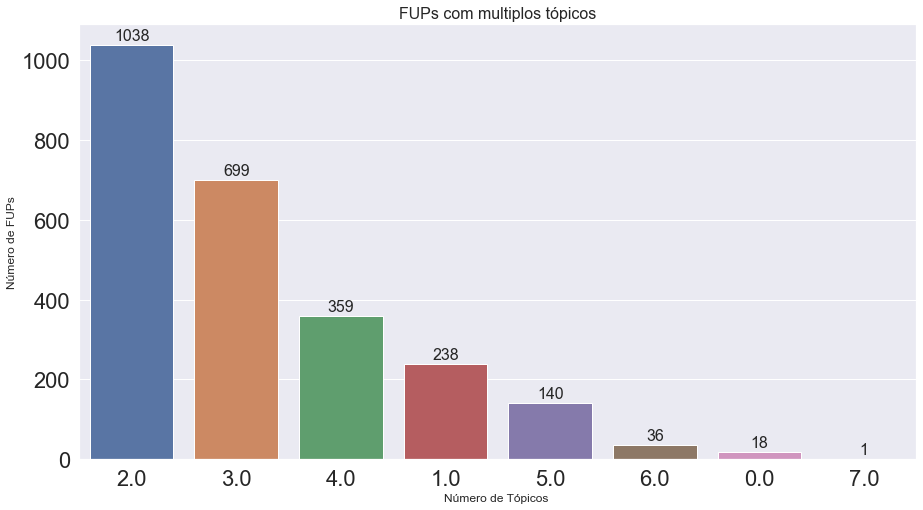

In [62]:
rowSums = nps_df.iloc[:,30:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[0:]

sns.set(font_scale = 2)
plt.figure(figsize=(15, 8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values, order=multiLabel_counts.index)

plt.title('FUPs com multiplos tópicos', fontsize=16)
plt.ylabel('Número de FUPs', fontsize=12)
plt.xlabel('Número de Tópicos ', fontsize=12)

#adding the next labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=16)

plt.show()

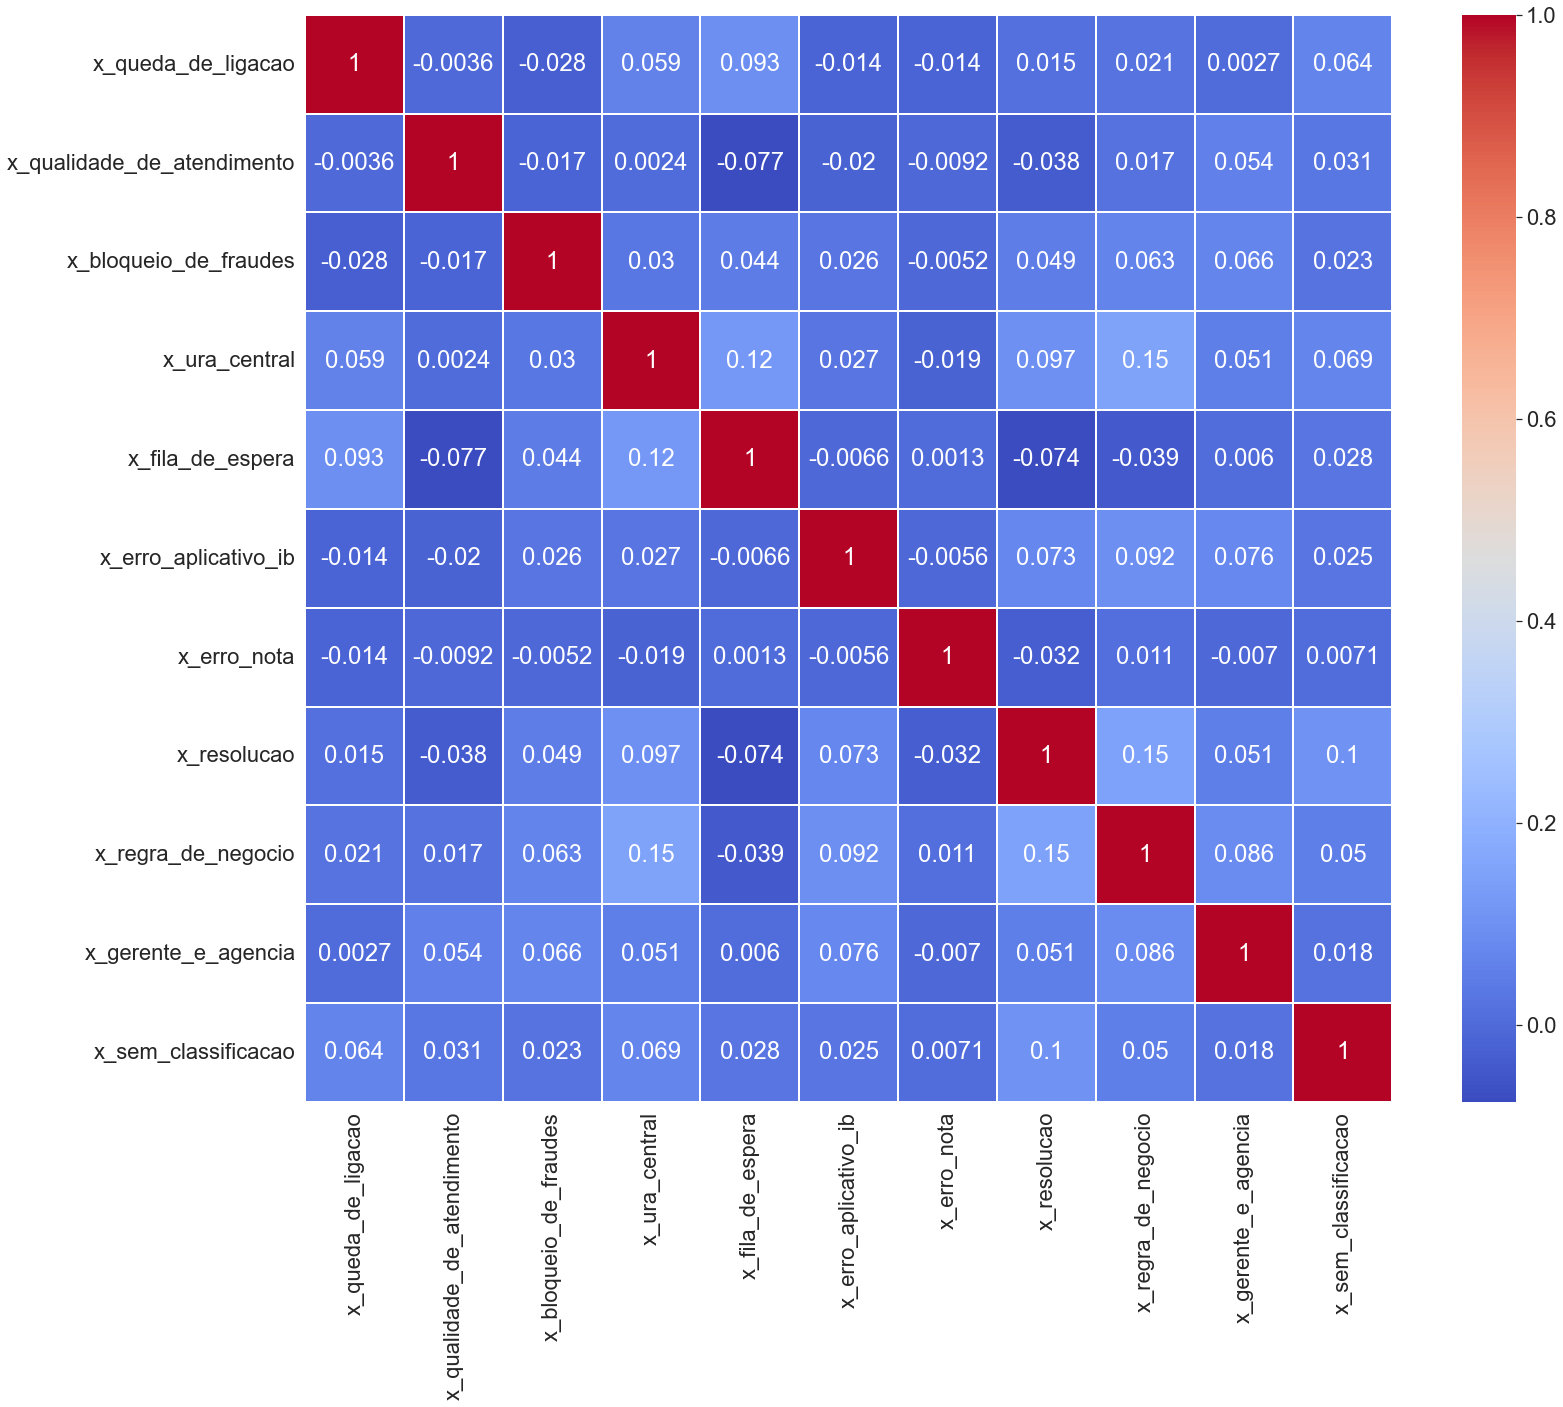

In [63]:
data = nps_df[['x_queda_de_ligacao', 
               'x_qualidade_de_atendimento', 
               'x_bloqueio_de_fraudes', 
               'x_ura_central', 
               'x_fila_de_espera',
               'x_erro_aplicativo_ib',
               'x_erro_nota',
               'x_resolucao',
               'x_regra_de_negocio',
               'x_gerente_e_agencia',
               'x_sem_classificacao']]

colormap = plt.cm.coolwarm
plt.figure(figsize = (25,20))

sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

#### Feature Selection

In [64]:
nps_df_model = nps_df[['cod_index', 'tx_coment', 'x_queda_de_ligacao', 
               'x_qualidade_de_atendimento', 
               'x_bloqueio_de_fraudes', 
               'x_ura_central', 
               'x_fila_de_espera',
               'x_erro_aplicativo_ib',
               'x_erro_nota',
               'x_resolucao',
               'x_regra_de_negocio',
               'x_gerente_e_agencia',
               'x_sem_classificacao']]

#### Train-Test

In [65]:
train, test = train_test_split(nps_df_model, random_state=0, test_size=0.3, shuffle=True)

print(train.shape)
print(test.shape)

train_text = train['tx_coment']
test_text = test['tx_coment']

(1770, 13)
(759, 13)


#### TF_IDF

In [66]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(ngram_range=(1, 3), strip_accents='unicode')

In [67]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['cod_index', 'tx_coment'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['cod_index', 'tx_coment'], axis=1)

#### MLkNN

In [78]:
%%time

classifier_new = MLkNN(k=11) #critical

x_train = lil_matrix(x_train).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(x_test).toarray()

#train
classifier_new.fit(x_train, y_train)

#predict
predictions_new = classifier_new.predict(x_test)

#accuracy
print('Accuracy = ', accuracy_score(y_test, predictions_new))
print('Hamming loss = ', hamming_loss(y_test, predictions_new))
print('\n')

c:\users\vinic\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=11 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy =  0.49538866930171277
Hamming loss =  0.07006827164929932


Wall time: 5.86 s


#### LDA

In [68]:
evaluate = nps_df['tx_coment'].astype(str)

count_vectorizer = TfidfVectorizer(stop_words=stopwords)

count_data = count_vectorizer.fit_transform(evaluate)

number_topics = 11
number_words = 5

TypeError: 'LazyCorpusLoader' object is not iterable

In [ ]:
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_index, topic in enumerate(model.components_):
        print(f"\'topic{topic_index}\':['"+"\',\'".join([words[i] for i in topic.argsort() [:-n_top_words -1:-1]]))
        
        
print('Topics found via LDA:')
print_topics(lda, count_vectorizer, number_words)

In [ ]:
#justar

In [ ]:
# dicionario de topicos
topics = {'topic0':['networks' , 'image' , 'model' , 'galaxies' , 'properties' , 'materials' , 'population'],
          'topic1':['problems' , 'based' , 'pseudo' , 'time' , '2d' , 'deterministic' , 'graphene'],
          'topic2':['mathfrak' , 'algebra' , 'î¼' , 'quantum' , 'paper' , 'type' , 'hbar'],
          'topic3':['rm' , 'log' , 'mass' , 'rate' , 'star' , 'adaptive' , 'm_'],
          'topic4':['graphene' , 'electron' , 'angle' , 'dirac' , 'reid' , 'galaxies' , 'valley']}

In [ ]:
# Função que pega uma lista de palavras e um texto como entrada e conta quantas vezes as palavras da lista aparecem no texto
def count_words(words, text):
    counter = 0
    for word in words:
        for w in text.split():
            if word == w:
                counter+= 1
    return counter

In [ ]:
# Função para classificar cada resumo em um tópico, verificando o tópico que contém mais palavras.
# Para cada resumo, cria um dicionário {topic: qtd words da lista} e depois verifica qual é a chave no dicionário com o maior número, que será o número do tópico a ser adicionado a uma lista e devolvido.

def assign_topic(topic, text):
    assign = []
    for row in text:
        topic_counts = {}
        for key, value in topic.items():
            topic_counts[key] = count_words(value, row) #use function previously created
        assign.append(max(topic_counts, key=lambda k: topic_counts[k]))
    return assign

In [ ]:
# A lista de tópicos que irão no dataframe
topics_list = assign_topic(topics, nps_df.tx_coment)

# Adicionando a coluna de tópicos ao dataframe
nps_df['topics'] = topics_list

In [ ]:
plt.figure(figsize=(7,7))
labels = topics.items()
sizes = nps_df.topics.value_counts()
plt.pie(sizes, autopct='%1.f%%', startangle=90, textprops={'fontsize':14})
plt.legend(labels, loc='center left', bbox_to_anchor=(1,0,0.5,1))
plt.show()

In [ ]:
DEFINIÇÃO DO PROBLEMA

Qual é o Problema? 
Gasto muito tempo classificando os FUPS manualmente 
Qual a solução ideal? 
Ter uma classificação que indique os assuntos mencionados no FUP. 
Como eu que posso fazer isso com Data Science/ML?
Criar uma solução de classificação dos assuntos.
Solução 1 - Algoritmo parametrizado para mineração de textos;
Solução 2 - Modelo de Classificação Multi-label;
Solução 3 - Modelo de Classificação;

Como essa solução será usada em produção? 
Abordagem com "ponto de corte" -> Ex: retornar apenas Top 3 Abordagem de ranking -> ordene os vídeos mais interessantes primeiro Web app com os vídeos (links) e as previsões ordenadas 

Executar o predict na base que contém o FUP e o resultado será adicionado na coluna consolidadora ou podemos utilizar a abordagem de Dummy;

*Em um segundo momento essa informação será adicionada a base/painel NPS.

Como eu vou saber que deu certo?
Métrica primária: dos top N vídeos, quantos eu coloco na lista de Watch Later. 
Métrica(s) secundária(s): quanto tempo eu passo selecionando vídeos


BRAINSTORM

HANDS ON

Solução 1
Ok - Concatenar todos os glossários com a base mês a mês do vitrine;
Ok - Identificar quais são os tópicos (glossários)
Ok - Gerar o glossário para avaliação local
Ok - Iterar o arquivo do glossário e capturar o nomes das planilhas; 
Ok - Para cada planilha copiar o conteúdo da coluna Palavras
Ok - Criar as colunas no DF de acordo com os tópicos (glossários) atribuindo o valor padrão: 0;
Ok - Importar os glossários do arquivo excel  para o algoritmo de NPS;
Ok - Inserir os glossários nas listas do algoritmo para classificação;
OK - Executar o pré-processamento dos textos: glossários e fup;
OK -Pre processamento: todas minúsculas, remoção de caracteres especiais, espaços no inicio/fim e outros ruídos que possam atrapalhar o processamento dos textos;
Executar o predict para aplicar as classificações;
Verificar se o FUP esta vazio e realizar a predição

Termos que pode generalizar muito: 'falar', 'virtual', 'secretaria', 'fazer'

REFERÊNCIAS:

Topic Extract LDA - NLP Gensin
https://youtu.be/aPMPyUoFH8U

https://github.com/gurezende/Studying/blob/master/MIT/Module%201/MIT%20Case%201.1.2.ipynb

https://medium.com/somos-tera/como-modelar-t%C3%B3picos-atrav%C3%A9s-de-latent-dirichlet-allocation-lda-atrav%C3%A9s-da-biblioteca-gensim-1fa17357ad4b

https://medium.com/somos-tera/trabalho-de-conclus%C3%A3o-de-curso-da-tera-data-science-machine-learning-6a34479e261b

https://medium.com/data-hackers/como-categorizar-textos-usando-o-lda-c47c5f6929a

https://sauter.digital/modelagem-de-topicos-em-python-utilizando-o-modelo-de-alocacao-latente-de-dirichlet-lda-2/

• Topic Modeling and Latent Dirichlet Allocation (LDA) in Python:  https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
• Evaluate Topic Models: Latent Dirichlet Allocation (LDA):  https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

https://ichi.pro/pt/percorrer-limpar-planilhas-em-lote-em-arquivos-excel-em-lote-e-interagir-com-o-mysql-31851900653963

# agrupando letras
http://localhost:8888/notebooks/_PY/_GIT/CienciadosDados/DCC_2/Agrupando%20letras%20LDA.ipynb

In [ ]:
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.cluster import KMeans

In [ ]:
from sklearn.cluster import MiniBatchKMeans

# escolhendo k
qualidade = pd.DataFrame(columns = ['k', 'ssd'])
for k in range(1,17, 1):
  # kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20)
  kmeans.fit(vec_text)
  qualidade = qualidade.append({'k': k, 'ssd' : kmeans.inertia_}, ignore_index=True)

alt.Chart(qualidade).mark_line(
    point=True
).encode(
    x = 'k',
    y = alt.Y('ssd', scale = alt.Scale(zero=False))
)

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, random_state=20)
#fit the data 
kmeans.fit(vec_text)
labels = kmeans.predict(vec_text)

letras_ag = letras.assign(grupo = labels)

letras_ag.sample(10)

In [ ]:
letras_ag['grupo'].value_counts()

In [ ]:
#this loop transforms the numbers back into words
common_words = kmeans.cluster_centers_.argsort()[:,-1:-15:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

In [ ]:
pd.options.display.max_colwidth = 100
letras_ag.query('grupo == 4')[['SName', 'Lyric', 'Artist']].sample(10)

In [ ]:
for g in range(0, 7):
  print('\n-----\nGRUPO {}:'.format(g))
  print(letras_ag.query('grupo ==  {}'.format(g))['Artist'].value_counts()[0:10])
  print('-----')

# fernando amaral

In [52]:
# Knn e Hierarquical ARAM NN
from skmultilearn.adapt import MLkNN, MLARAM
#transformação de problemas
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss

In [80]:
#adaptado
#vizinho mais próximo para ML
vmp = MLkNN(k=11) 
vmp.fit(x_train, y_train)

c:\users\vinic\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=11 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


MLkNN(k=11)

In [81]:
#previsão com dados de teste
previsto = vmp.predict(x_test) 
#hamming para avaliar preformance  
print(hamming_loss(y_test, previsto)) 

0.07006827164929932


In [82]:
#segundo classificador adaptado, Hierarquical ARAM NN
ann = MLARAM()
ann.fit(x_train, y_train) 

MLARAM(neurons=[<skmultilearn.adapt.mlaram.Neuron object at 0x000001D2DA0D5520>,
                <skmultilearn.adapt.mlaram.Ne...
                <skmultilearn.adapt.mlaram.Neuron object at 0x000001D2DC97F1F0>, ...])

In [84]:
#previsão com dados de teste
previsto = ann.predict(x_test) 
#hamming para avaliar preformance  
print(hamming_loss(y_test, previsto))

0.07090669541262426


In [85]:
#transformação de problema
#binary relevance
binary = BinaryRelevance(classifier = SVC())
binary.fit(x_train, y_train)
previsao = binary.predict(x_test)
print(hamming_loss(y_test, previsao))

0.06791232482932087


In [86]:
#transformação de problema
#ClassifierChain
chain = ClassifierChain(classifier = SVC())
chain.fit(x_train, y_train)
previsoes = chain.predict(x_test)
print(hamming_loss(y_test,previsoes))

0.0992933285423404


In [87]:
#transformação de problema
#labelpowerset
label = LabelPowerset(classifier = SVC())
label.fit(x_train, y_train)
previsoes = label.predict(x_test)
print(hamming_loss(y_test,previsoes))

0.08563899868247694
